In [1]:
import numpy as np
from os import path
from skimage import io
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import ipywidgets as widgets
from sklearn.metrics import accuracy_score

In [2]:
import A1.model, A2.model, B1.model, B2.model

2023-01-03 16:30:38.790507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Functions for loading data

In [3]:
LABELS = 'labels.csv'
DATASETS = 'Datasets'
IMGS = 'img'
TEST = '_test'

def load_data(folder, feature_col, file_col, load_image, augment=False):
    filenames, y = np.genfromtxt(
        path.join(DATASETS,folder,LABELS),
        usecols=(file_col,feature_col),
        dtype='U10,i8',
        unpack=True,
        skip_header=1,
        delimiter='\t'
    )
    y = np.maximum(y,0) # convert -1 label to 0
    imagedir = path.join(DATASETS,folder,IMGS)
    n = len(filenames)
    shape = load_image(path.join(imagedir,filenames[0])).shape # get first image to get shape
    X = np.empty((n*2 if augment else n, *shape), dtype=np.uint8) # pre-define X, much more efficient than concatenating arrays
    for i in tqdm(range(n), desc=folder): # tqdm displays a nice loading bar
        X[i] = load_image(path.join(imagedir,filenames[i]))
    if augment:
        X[n:] = X[:n,:,::-1]  # copy images, but reverse left to right
        y = np.tile(y,2) # duplicate labels
    print(f'Loaded {X.nbytes:,} bytes')
    return X, y


Each task uses a different comibination of dataset, feature_col, file_col, and module:

In [4]:
TASKS = {'A1':('celeba',2,1,A1), 'A2':('celeba',3,1,A2), 'B1':('cartoon_set',2,3,B1),'B2':('cartoon_set',1,3,B2)}
task = widgets.Dropdown(options=TASKS, description='Task')
task

Dropdown(description='Task', options={'A1': ('celeba', 2, 1, <module 'A1' (namespace)>), 'A2': ('celeba', 3, 1…

In [5]:
dataset, feature_col, file_col, task_module = task.value
model = task_module.model

In [6]:
X, y = load_data(dataset, feature_col, file_col, model.load_image, augment=task.label.startswith('A'))

celeba:   0%|          | 0/5000 [00:00<?, ?it/s]

Loaded 63,000,000 bytes


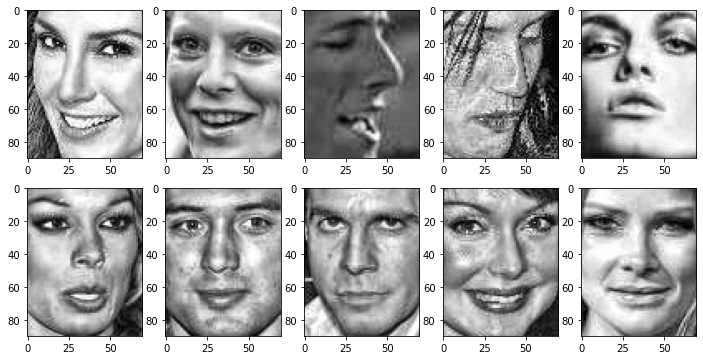

In [7]:
plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i], cmap='gray')
plt.show()

In [8]:
X_test, y_test = load_data(dataset+TEST, feature_col, file_col, model.load_image)

celeba_test:   0%|          | 0/1000 [00:00<?, ?it/s]

Loaded 6,300,000 bytes


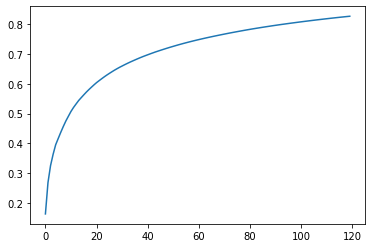

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 185
max_resources_: 5000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 75
n_resources: 185
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 1/5] END C=0.5, gamma=0.001, kernel=rbf;, score=(train=0.818, test=0.730) total time=   0.0s
[CV 2/5] END C=0.5, gamma=0.001, kernel=rbf;, score=(train=0.811, test=0.703) total time=   0.0s
[CV 3/5] END C=0.5, gamma=0.001, kernel=rbf;, score=(train=0.831, test=0.595) total time=   0.0s
[CV 4/5] END C=0.5, gamma=0.001, kernel=rbf;, score=(train=0.811, test=0.595) total time=   0.0s
[CV 5/5] END C=0.5, gamma=0.001, kernel=rbf;, score=(train=0.818, test=0.730) total time=   0.0s
[CV 1/5] END C=0.5, gamma=0.001, kernel=sigmoid;, score=(train=0.784, test=0.703) total time=   0.0s
[CV 2/5] END C=0.5, gamma=0.001, kernel=sigmoid;, score=(train=0.791, test=0.676) total time=   0.0s
[CV 3/5] END C=0.5, gamma=0.001, kernel=sigmoid;, s

[CV 4/5] END C=1, gamma=0.001, kernel=sigmoid;, score=(train=0.838, test=0.649) total time=   0.0s
[CV 5/5] END C=1, gamma=0.001, kernel=sigmoid;, score=(train=0.818, test=0.703) total time=   0.0s
[CV 1/5] END C=1, gamma=0.001, kernel=linear;, score=(train=1.000, test=0.892) total time=   0.0s
[CV 2/5] END C=1, gamma=0.001, kernel=linear;, score=(train=1.000, test=0.730) total time=   0.0s
[CV 3/5] END C=1, gamma=0.001, kernel=linear;, score=(train=1.000, test=0.784) total time=   0.0s
[CV 4/5] END C=1, gamma=0.001, kernel=linear;, score=(train=1.000, test=0.865) total time=   0.0s
[CV 5/5] END C=1, gamma=0.001, kernel=linear;, score=(train=1.000, test=0.784) total time=   0.0s
[CV 1/5] END C=1, gamma=0.003, kernel=rbf;, score=(train=0.966, test=0.757) total time=   0.0s
[CV 2/5] END C=1, gamma=0.003, kernel=rbf;, score=(train=0.946, test=0.784) total time=   0.0s
[CV 3/5] END C=1, gamma=0.003, kernel=rbf;, score=(train=0.966, test=0.784) total time=   0.0s
[CV 4/5] END C=1, gamma=0.0

[CV 5/5] END C=2, gamma=0.003, kernel=rbf;, score=(train=0.993, test=0.865) total time=   0.0s
[CV 1/5] END C=2, gamma=0.003, kernel=sigmoid;, score=(train=0.912, test=0.892) total time=   0.0s
[CV 2/5] END C=2, gamma=0.003, kernel=sigmoid;, score=(train=0.878, test=0.838) total time=   0.0s
[CV 3/5] END C=2, gamma=0.003, kernel=sigmoid;, score=(train=0.885, test=0.838) total time=   0.0s
[CV 4/5] END C=2, gamma=0.003, kernel=sigmoid;, score=(train=0.845, test=0.757) total time=   0.0s
[CV 5/5] END C=2, gamma=0.003, kernel=sigmoid;, score=(train=0.865, test=0.784) total time=   0.0s
[CV 1/5] END C=2, gamma=0.003, kernel=linear;, score=(train=1.000, test=0.892) total time=   0.0s
[CV 2/5] END C=2, gamma=0.003, kernel=linear;, score=(train=1.000, test=0.730) total time=   0.0s
[CV 3/5] END C=2, gamma=0.003, kernel=linear;, score=(train=1.000, test=0.784) total time=   0.0s
[CV 4/5] END C=2, gamma=0.003, kernel=linear;, score=(train=1.000, test=0.865) total time=   0.0s
[CV 5/5] END C=2, 

[CV 4/5] END C=5, gamma=0.01, kernel=sigmoid;, score=(train=0.655, test=0.622) total time=   0.0s
[CV 5/5] END C=5, gamma=0.01, kernel=sigmoid;, score=(train=0.655, test=0.730) total time=   0.0s
[CV 1/5] END C=5, gamma=0.01, kernel=linear;, score=(train=1.000, test=0.892) total time=   0.0s
[CV 2/5] END C=5, gamma=0.01, kernel=linear;, score=(train=1.000, test=0.730) total time=   0.0s
[CV 3/5] END C=5, gamma=0.01, kernel=linear;, score=(train=1.000, test=0.784) total time=   0.0s
[CV 4/5] END C=5, gamma=0.01, kernel=linear;, score=(train=1.000, test=0.865) total time=   0.0s
[CV 5/5] END C=5, gamma=0.01, kernel=linear;, score=(train=1.000, test=0.784) total time=   0.0s
[CV 1/5] END C=5, gamma=0.03, kernel=rbf;, score=(train=1.000, test=0.568) total time=   0.0s
[CV 2/5] END C=5, gamma=0.03, kernel=rbf;, score=(train=1.000, test=0.568) total time=   0.0s
[CV 3/5] END C=5, gamma=0.03, kernel=rbf;, score=(train=1.000, test=0.703) total time=   0.0s
[CV 4/5] END C=5, gamma=0.03, kernel=

[CV 2/5] END C=10, gamma=0.03, kernel=linear;, score=(train=1.000, test=0.730) total time=   0.0s
[CV 3/5] END C=10, gamma=0.03, kernel=linear;, score=(train=1.000, test=0.784) total time=   0.0s
[CV 4/5] END C=10, gamma=0.03, kernel=linear;, score=(train=1.000, test=0.865) total time=   0.0s
[CV 5/5] END C=10, gamma=0.03, kernel=linear;, score=(train=1.000, test=0.784) total time=   0.0s
[CV 1/5] END C=10, gamma=0.1, kernel=rbf;, score=(train=1.000, test=0.568) total time=   0.0s
[CV 2/5] END C=10, gamma=0.1, kernel=rbf;, score=(train=1.000, test=0.568) total time=   0.0s
[CV 3/5] END C=10, gamma=0.1, kernel=rbf;, score=(train=1.000, test=0.622) total time=   0.0s
[CV 4/5] END C=10, gamma=0.1, kernel=rbf;, score=(train=1.000, test=0.649) total time=   0.0s
[CV 5/5] END C=10, gamma=0.1, kernel=rbf;, score=(train=1.000, test=0.514) total time=   0.0s
[CV 1/5] END C=10, gamma=0.1, kernel=sigmoid;, score=(train=0.608, test=0.595) total time=   0.0s
[CV 2/5] END C=10, gamma=0.1, kernel=sig

[CV 5/5] END C=1, gamma=0.001, kernel=linear;, score=(train=0.998, test=0.766) total time=   0.1s
[CV 1/5] END C=5, gamma=0.001, kernel=linear;, score=(train=1.000, test=0.892) total time=   0.0s
[CV 2/5] END C=5, gamma=0.001, kernel=linear;, score=(train=1.000, test=0.802) total time=   0.0s
[CV 3/5] END C=5, gamma=0.001, kernel=linear;, score=(train=1.000, test=0.883) total time=   0.0s
[CV 4/5] END C=5, gamma=0.001, kernel=linear;, score=(train=1.000, test=0.802) total time=   0.0s
[CV 5/5] END C=5, gamma=0.001, kernel=linear;, score=(train=1.000, test=0.721) total time=   0.1s
[CV 1/5] END C=5, gamma=0.003, kernel=rbf;, score=(train=1.000, test=0.883) total time=   0.0s
[CV 2/5] END C=5, gamma=0.003, kernel=rbf;, score=(train=1.000, test=0.847) total time=   0.0s
[CV 3/5] END C=5, gamma=0.003, kernel=rbf;, score=(train=1.000, test=0.892) total time=   0.0s
[CV 4/5] END C=5, gamma=0.003, kernel=rbf;, score=(train=1.000, test=0.856) total time=   0.0s
[CV 5/5] END C=5, gamma=0.003, k

[CV 4/5] END C=10, gamma=0.001, kernel=sigmoid;, score=(train=0.907, test=0.889) total time=   0.1s
[CV 5/5] END C=10, gamma=0.001, kernel=sigmoid;, score=(train=0.895, test=0.862) total time=   0.1s
[CV 1/5] END C=10, gamma=0.001, kernel=rbf;, score=(train=0.981, test=0.949) total time=   0.2s
[CV 2/5] END C=10, gamma=0.001, kernel=rbf;, score=(train=0.983, test=0.898) total time=   0.1s
[CV 3/5] END C=10, gamma=0.001, kernel=rbf;, score=(train=0.978, test=0.922) total time=   0.2s
[CV 4/5] END C=10, gamma=0.001, kernel=rbf;, score=(train=0.985, test=0.919) total time=   0.2s
[CV 5/5] END C=10, gamma=0.001, kernel=rbf;, score=(train=0.983, test=0.919) total time=   0.2s
[CV 1/5] END C=2, gamma=0.001, kernel=rbf;, score=(train=0.950, test=0.940) total time=   0.2s
[CV 2/5] END C=2, gamma=0.001, kernel=rbf;, score=(train=0.951, test=0.889) total time=   0.2s
[CV 3/5] END C=2, gamma=0.001, kernel=rbf;, score=(train=0.947, test=0.916) total time=   0.2s
[CV 4/5] END C=2, gamma=0.001, kern

In [9]:
print("Accuracy on trained data:", model.fit(X, y))

In [10]:
y_pred = model.predict(X_test)

In [11]:
print("Accuracy on test data:", accuracy_score(y_test,y_pred))

Accuracy on test data: 0.951


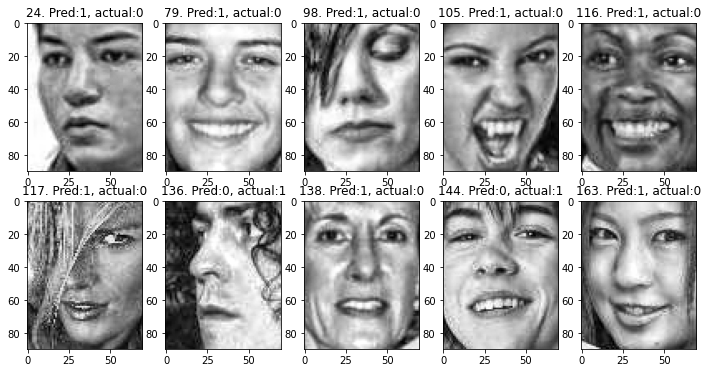

In [12]:
wrong, = np.nonzero(y_test!=y_pred)
plt.figure(figsize=(12,6))
for w,i in enumerate(wrong[:10]): # show first 10 that are wrong
    plt.subplot(2, 5, w+1)
    plt.title(str(i)+'. Pred:'+str(y_pred[i])+', actual:'+str(y_test[i]))
    plt.imshow(X_test[i], cmap='gray')
plt.show()